In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
import utils
from sklearn.metrics import roc_auc_score,accuracy_score,f1_score
import matplotlib.pyplot as plt
import pprint

In [160]:
df=pd.read_csv("cleaned_data.csv")

In [161]:
params_dist={
    "C":[1e-4,1e-3,1e-2,1e-1,1,1e1,1e2,1e3,1e4],
    'class_weight':["balanced",None],
    'fit_intercept':[True,False],
    'penalty':['l1','l2','elasticnet',None],
    'solver':['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
}

In [162]:
rf = RandomizedSearchCV(estimator=LogisticRegression(random_state=42,max_iter=1500),n_iter=100,random_state=42,scoring=[
    'roc_auc'
],param_distributions=params_dist,verbose=1,refit="roc_auc")

In [163]:
def compare_C(result):
    C_small_eval_high = result.query('param_C < 1 & mean_test_roc_auc >= 0.9')[['param_C','mean_test_roc_auc']]
    C_big_eval_high   = result.query('param_C >= 1 & mean_test_roc_auc >= 0.9')[['param_C','mean_test_roc_auc']]

    fig, ax = plt.subplots(1,2,sharey=True,figsize=(10,4))


    ax[0].scatter(result[result['param_C']<1].param_C,
                result[result['param_C']<1]['mean_test_roc_auc'])
    ax[0].scatter(C_small_eval_high.param_C, C_small_eval_high.mean_test_roc_auc,
                label='AUC validation >= 90%')
    ax[0].set_title("Small C (<1)")
    ax[0].set_xlabel("C")
    ax[0].set_xscale("log")
    ax[0].legend()


    ax[1].scatter(result[result['param_C']>=1].param_C,
                result[result['param_C']>=1]['mean_test_roc_auc'])
    ax[1].scatter(C_big_eval_high.param_C, C_big_eval_high.mean_test_roc_auc,
                label='AUC validation >= 90%')
    ax[1].set_title("Big C (>=1)")
    ax[1].set_xlabel("C")
    ax[1].set_xscale("log")
    ax[1].legend()

    plt.tight_layout()
    plt.show()

def compare_solver(result):
    solver_auc_score=result[['param_solver','mean_test_roc_auc']].groupby('param_solver').mean_test_roc_auc.max().sort_values(ascending=True)
    plt.title("auc per solvers ")
    plt.barh(solver_auc_score.index,width=solver_auc_score.values)
    plt.show()
def compare_pinalty(result):
    pinalty_auc_score=result[['param_penalty','mean_test_roc_auc']].groupby('param_penalty').mean_test_roc_auc.max().sort_values(ascending=True)
    plt.title("auc per pinaltys ")
    plt.barh(pinalty_auc_score.index,width=pinalty_auc_score.values)
    plt.show()

In [164]:
def store_result(base_model,base_score,rs:RandomizedSearchCV,rf_score):
    return (
        base_model,
        rs.best_estimator_
        ,{
            'best_params':rs.best_params_,
            'best_score':rs.best_score_,
            'base_score':base_score,
            'rf_score':rf_score,
            'diff':rf_score-base_score
        }
    )


## without Normalisation


In [165]:
(Xtrain,ytrain),(Xtest,ytest)=utils.get_train_test(df,'target')

In [166]:
base =LogisticRegression(random_state=42,max_iter=1500).fit(Xtrain,ytrain)
proba=base.predict_proba(Xtest)
base_score=roc_auc_score(ytest,proba[:,1])
print("base_score",base_score)

base_score 0.9069061779342152


In [167]:
rf.fit(Xtrain,ytrain)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore

RandomizedSearchCV(estimator=LogisticRegression(max_iter=1500, random_state=42),
                   n_iter=100,
                   param_distributions={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10.0,
                                              100.0, 1000.0, 10000.0],
                                        'class_weight': ['balanced', None],
                                        'fit_intercept': [True, False],
                                        'penalty': ['l1', 'l2', 'elasticnet',
                                                    None],
                                        'solver': ['lbfgs', 'liblinear',
                                                   'newton-cg',
                                                   'newton-cholesky', 'sag',
                                                   'saga']},
                   random_state=42, refit='roc_auc', scoring=['roc_auc'],
                   verbose=1)

In [168]:
result=pd.DataFrame(rf.cv_results_)

In [169]:
result = result.replace({None:'None'}).dropna()

In [170]:
result.to_csv("LOR-NoNorm-.csv")

In [171]:
result[["params",'mean_test_roc_auc']].head()

,params,mean_test_roc_auc
0,"{'solver': 'lbfgs', 'penalty': 'l2', 'fit_inte...",0.880652
2,"{'solver': 'saga', 'penalty': 'l2', 'fit_inter...",0.885806
3,"{'solver': 'newton-cholesky', 'penalty': None,...",0.912481
4,"{'solver': 'saga', 'penalty': None, 'fit_inter...",0.885845
5,"{'solver': 'saga', 'penalty': 'l2', 'fit_inter...",0.884611


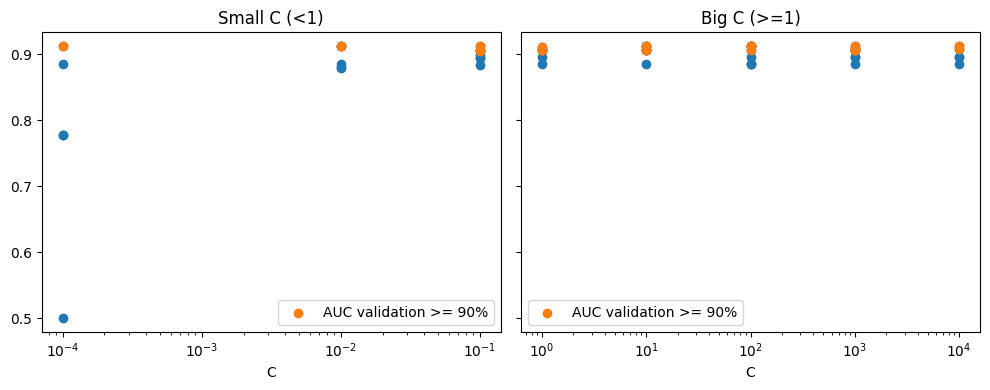

In [172]:
compare_C(result)

multiple values for C makes the performence of the model good


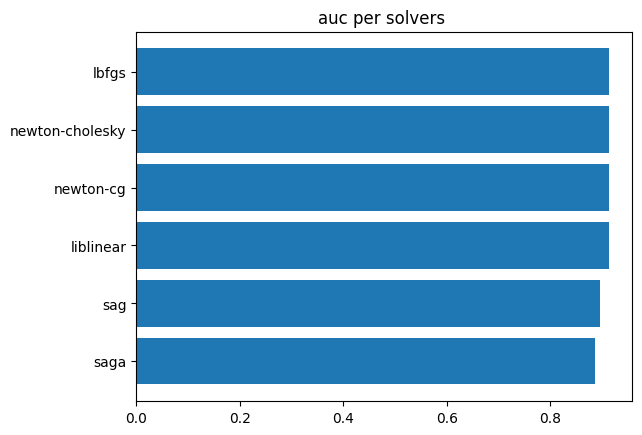

In [173]:
compare_solver(result)

the solvers lbfgs /liblinear / newton-chlesky newton-cg are the best solvers founds


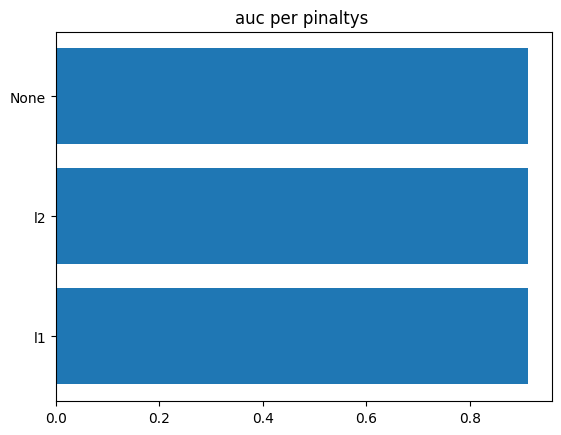

In [174]:
compare_pinalty(result)

Pinalty l1/l2 are good for the model


In [175]:
proba=rf.predict_proba(Xtest)
score_rf=roc_auc_score(ytest,proba[:,1])

In [176]:
artifact_rs_without_norm=store_result(base,base_score,rf,score_rf)

In [177]:
artifact_rs_without_norm

(LogisticRegression(max_iter=1500, random_state=42),
 LogisticRegression(C=0.0001, max_iter=1500, penalty=None, random_state=42),
 {'best_params': {'solver': 'lbfgs',
   'penalty': None,
   'fit_intercept': True,
   'class_weight': None,
   'C': 0.0001},
  'best_score': np.float64(0.9128932288613051),
  'base_score': np.float64(0.9069061779342152),
  'rf_score': np.float64(0.9078771695594124),
  'diff': np.float64(0.0009709916251972039)})

## with minmax


In [178]:
(Xtrain,ytrain),(Xtest,ytest)=utils.get_train_test(df,'target','minmax')

In [179]:
base =LogisticRegression(random_state=42,max_iter=1500).fit(Xtrain,ytrain)
proba=base.predict_proba(Xtest)
score=roc_auc_score(ytest,proba[:,1])
print("base_score",score)

base_score 0.9090909090909091


In [180]:
rf.fit(Xtrain,ytrain)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and

RandomizedSearchCV(estimator=LogisticRegression(max_iter=1500, random_state=42),
                   n_iter=100,
                   param_distributions={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10.0,
                                              100.0, 1000.0, 10000.0],
                                        'class_weight': ['balanced', None],
                                        'fit_intercept': [True, False],
                                        'penalty': ['l1', 'l2', 'elasticnet',
                                                    None],
                                        'solver': ['lbfgs', 'liblinear',
                                                   'newton-cg',
                                                   'newton-cholesky', 'sag',
                                                   'saga']},
                   random_state=42, refit='roc_auc', scoring=['roc_auc'],
                   verbose=1)

In [181]:
result_minmax=pd.DataFrame(rf.cv_results_)
result_minmax = result_minmax.replace({None:'None'}).dropna()
result_minmax.to_csv("LOR-minmax.csv")

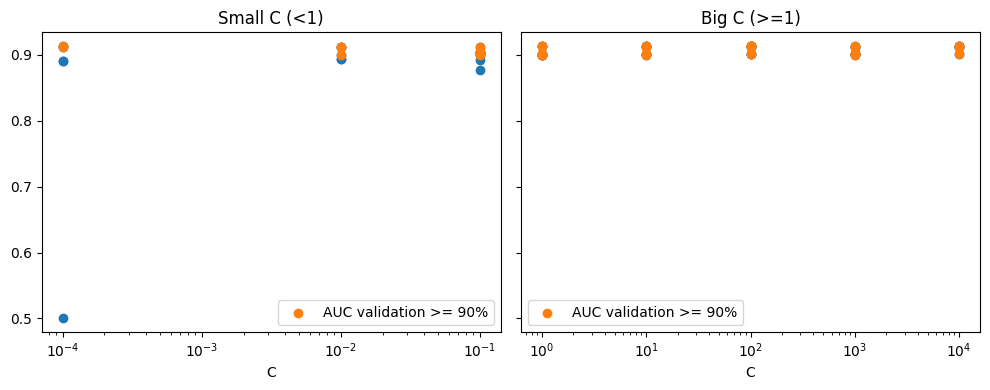

In [182]:
compare_C(result_minmax)

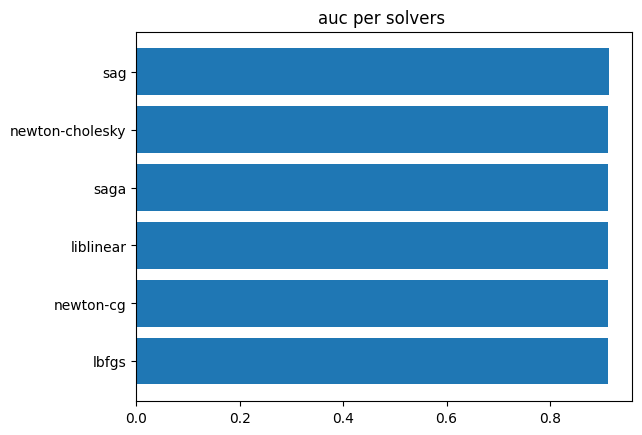

In [183]:
compare_solver(result_minmax)

In [185]:
proba=rf.predict_proba(Xtest)
score_rf=roc_auc_score(ytest,proba[:,1])

In [186]:
artifact_rs_minmax=store_result(base,score,rf,score_rf)

## With Standard


In [187]:
(Xtrain,ytrain),(Xtest,ytest)=utils.get_train_test(df,'target','standard')

In [188]:
base =LogisticRegression(random_state=42,max_iter=1500).fit(Xtrain,ytrain)
proba=base.predict_proba(Xtest)
score=roc_auc_score(ytest,proba[:,1])
print("base_score",score)

base_score 0.9078771695594127


In [189]:
rf.fit(Xtrain,ytrain)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and

RandomizedSearchCV(estimator=LogisticRegression(max_iter=1500, random_state=42),
                   n_iter=100,
                   param_distributions={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10.0,
                                              100.0, 1000.0, 10000.0],
                                        'class_weight': ['balanced', None],
                                        'fit_intercept': [True, False],
                                        'penalty': ['l1', 'l2', 'elasticnet',
                                                    None],
                                        'solver': ['lbfgs', 'liblinear',
                                                   'newton-cg',
                                                   'newton-cholesky', 'sag',
                                                   'saga']},
                   random_state=42, refit='roc_auc', scoring=['roc_auc'],
                   verbose=1)

In [190]:
result_standard=pd.DataFrame(rf.cv_results_)
result_standard = result_standard.replace({None:'None'}).dropna()
result_standard.to_csv("LOR-standard.csv")

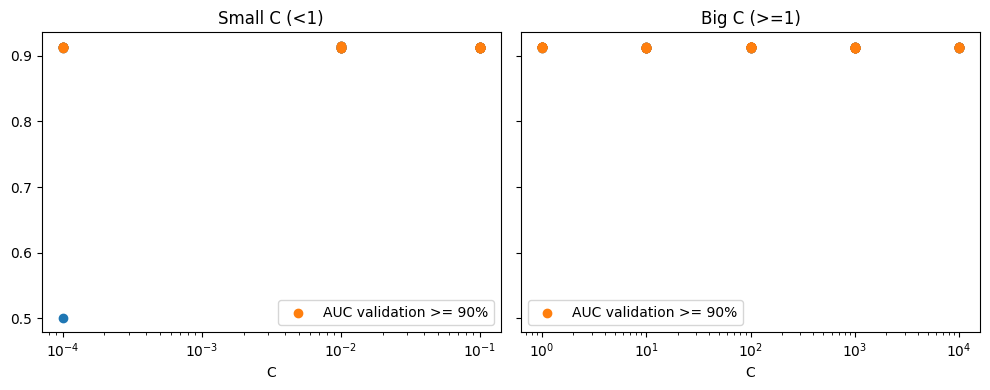

In [191]:
compare_C(result_standard)

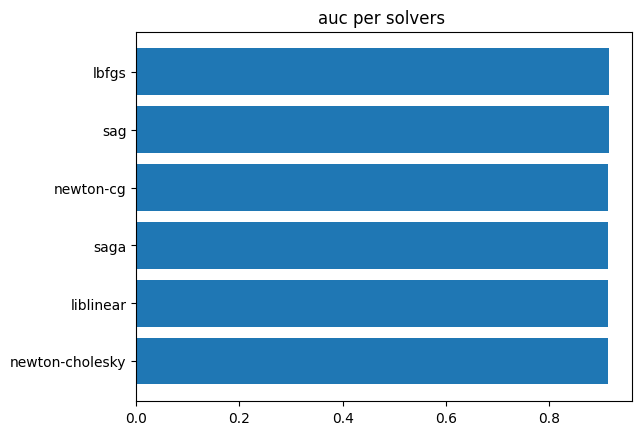

In [192]:
compare_solver(result_standard)

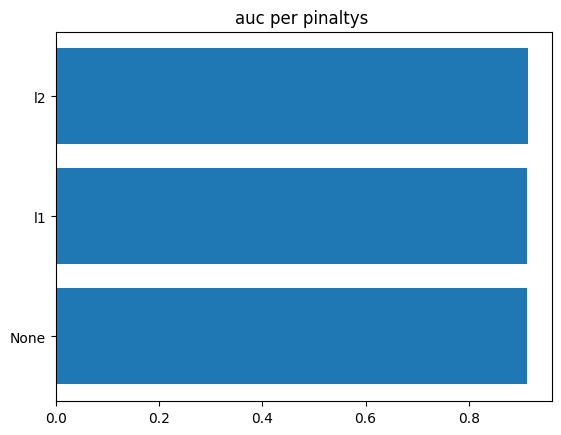

In [193]:
compare_pinalty(result_standard)

In [194]:
proba=rf.predict_proba(Xtest)
score_rf=roc_auc_score(ytest,proba[:,1])

In [195]:
artifact_rs_standard=store_result(base,score,rf,score_rf)

## comparaison between the base model and tunned model for auc


In [196]:
pprint.PrettyPrinter(indent=4).pprint(artifact_rs_without_norm)

(   LogisticRegression(max_iter=1500, random_state=42),
    LogisticRegression(C=0.0001, max_iter=1500, penalty=None, random_state=42),
    {   'base_score': np.float64(0.9069061779342152),
        'best_params': {   'C': 0.0001,
                           'class_weight': None,
                           'fit_intercept': True,
                           'penalty': None,
                           'solver': 'lbfgs'},
        'best_score': np.float64(0.9128932288613051),
        'diff': np.float64(0.0009709916251972039),
        'rf_score': np.float64(0.9078771695594124)})


improve by 0.009 in auc


In [197]:
pprint.PrettyPrinter(indent=4).pprint(artifact_rs_minmax)

(   LogisticRegression(max_iter=1500, random_state=42),
    LogisticRegression(C=1, max_iter=1500, random_state=42, solver='sag'),
    {   'base_score': np.float64(0.9090909090909091),
        'best_params': {   'C': 1,
                           'class_weight': None,
                           'fit_intercept': True,
                           'penalty': 'l2',
                           'solver': 'sag'},
        'best_score': np.float64(0.9134244950890889),
        'diff': np.float64(-0.00012137395314959498),
        'rf_score': np.float64(0.9089695351377595)})


no improvement


In [198]:
pprint.PrettyPrinter(indent=4).pprint(artifact_rs_standard)

(   LogisticRegression(max_iter=1500, random_state=42),
    LogisticRegression(C=0.01, class_weight='balanced', max_iter=1500,
                   random_state=42),
    {   'base_score': np.float64(0.9078771695594127),
        'best_params': {   'C': 0.01,
                           'class_weight': 'balanced',
                           'fit_intercept': True,
                           'penalty': 'l2',
                           'solver': 'lbfgs'},
        'best_score': np.float64(0.9150109790553407),
        'diff': np.float64(-0.004369462313387751),
        'rf_score': np.float64(0.9035077072460249)})


no improvment


## comparaison between the approch without normalisation and with normalisation


In [199]:
without_norm_pred=artifact_rs_without_norm[0].predict(Xtest)
minmax_pred=artifact_rs_minmax[0].predict(Xtest)
standard_pred=artifact_rs_standard[0].predict(Xtest)

In [200]:
without_norm_proba=artifact_rs_without_norm[0].predict_proba(Xtest)
minmax_proba=artifact_rs_minmax[0].predict_proba(Xtest)
standard_proba=artifact_rs_standard[0].predict_proba(Xtest)

In [201]:
accuracy_score(ytest,without_norm_pred),accuracy_score(ytest,minmax_pred),accuracy_score(ytest,standard_pred)

(0.45652173913043476, 0.657608695652174, 0.8478260869565217)

with standardisation we get high accuracy


In [202]:
f1_score(ytest,without_norm_pred),f1_score(ytest,minmax_pred),f1_score(ytest,standard_pred)
#

(0.13793103448275862, 0.5987261146496815, 0.8627450980392157)

with standardisation we get high f1score


In [203]:
roc_auc_score(ytest,without_norm_proba[:,1]),roc_auc_score(ytest,minmax_proba[:,1]),roc_auc_score(ytest,standard_proba[:,1])
#

(np.float64(0.9015657239956305),
 np.float64(0.9012016021361816),
 np.float64(0.9078771695594127))

with standardisation we get high auc


In [204]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

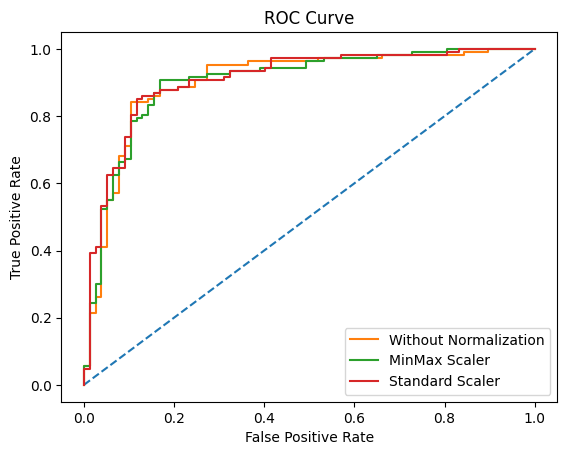

In [205]:
fp_norm_none,tp_norm_none,_ = roc_curve(ytest,without_norm_proba[:,1])
fp_minmax,tp_minmax,_       = roc_curve(ytest,minmax_proba[:,1])
fp_standard,tp_standard,_   = roc_curve(ytest,standard_proba[:,1])

plt.figure()
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")


plt.plot([0,1],[0,1], linestyle='--')

plt.plot(fp_norm_none,tp_norm_none, label="Without Normalization")
plt.plot(fp_minmax,tp_minmax, label="MinMax Scaler")
plt.plot(fp_standard,tp_standard, label="Standard Scaler")

plt.legend()
plt.show()


# Threshold tunning


In [240]:
import numpy as np

thresolds=np.arange(0.1,1,0.01)
result_th_tuning=[]
for thresold in thresolds:
    y_pred_none = (without_norm_proba[:,1] >= thresold).astype(int)
    y_pred_minmax = (minmax_proba[:,1] >= thresold).astype(int)
    y_pred_std = (standard_proba[:,1] >= thresold).astype(int)

    result_th_tuning.append([
        accuracy_score(ytest,y_pred_none),
        accuracy_score(ytest,y_pred_minmax),
        accuracy_score(ytest,y_pred_std),
    ])


In [247]:
np.max(result_th_tuning,axis=0)

array([0.55978261, 0.73913043, 0.85869565])

In [248]:
np.argmax(result_th_tuning,axis=0)

array([ 0,  0, 22])

In [250]:
thresolds[np.argmax(result_th_tuning,axis=0)[2]]

np.float64(0.3199999999999999)

threshold 0.3199 is the best for the model
